# ***L01:*** Partial Dependency (PDP) and Individual Conditional Expectation (ICE) Plots

<img src="./static/LO1.png" alt="LO1 Image" style="width: 50%; height: auto;">

In this notebook, you will explore the utility and limitations of Partial Dependency (PDP) and Individual Conditional Expectation (ICE) plots. You have two pairs of datasets and models to work with.

The first pair consists of a bike rental dataset (bike_sharing_data.csv) and its corresponding model (bike_sharing_model.pkl). This dataset includes four features: temp, feel_temp, humidity, and windspeed, each of which affects the number of bike rentals differently. In Section 1, you will test your understanding of PDP and ICE concepts by generating your own code to replicate the results from sklearn's built-in PDP and ICE plotting functions.

The second pair is a mystery dataset (mystery_data.csv) and its model (mystery_model.pkl). The mystery dataset contains only two binary features. In Section 2, you will analyze this dataset and try to determine the model's decision-making process. It is important to note that the mystery model has a 100% classification accuracy.

-------------------------

### Section 1 | Understand PDP and ICE curves by replicating sklearn plots with your own code

- 1.1 | Manually compute the PDP curve for the target feature "temp" and plot the result  
- 1.2 | Manually compute the ICE curves for the target feature of "temp" and plot the results    
- 1.3 | Center the ICE curves and plot the results as well as the average on the same axes  
- 1.4 | Discuss your results  

### Section 2 | Try and determine what rule the mystery model is using for its predictions on the mystery dataset  

- 2.1 | Plot the PDP and ICE curves for both "Feature1" and "Feature2"  
- 2.2 | Analyze and discuss the results. If you cannot explain the model's decisions, then argue your point.  

-----------------------

Import necessary libraries

In [21]:
import joblib # for saving and loading models from sklearn
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for data visualization
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay # for displaying partial dependence plots and individual conditional expectation
import warnings # filter warnings
warnings.filterwarnings("ignore")

Import the model and data

In [22]:
model = joblib.load('../models/bike_sharing_model.pkl')
data = pd.read_csv('../data/bike_sharing_data.csv')

Use sklearn's built-in function to plot the ICE and PDP

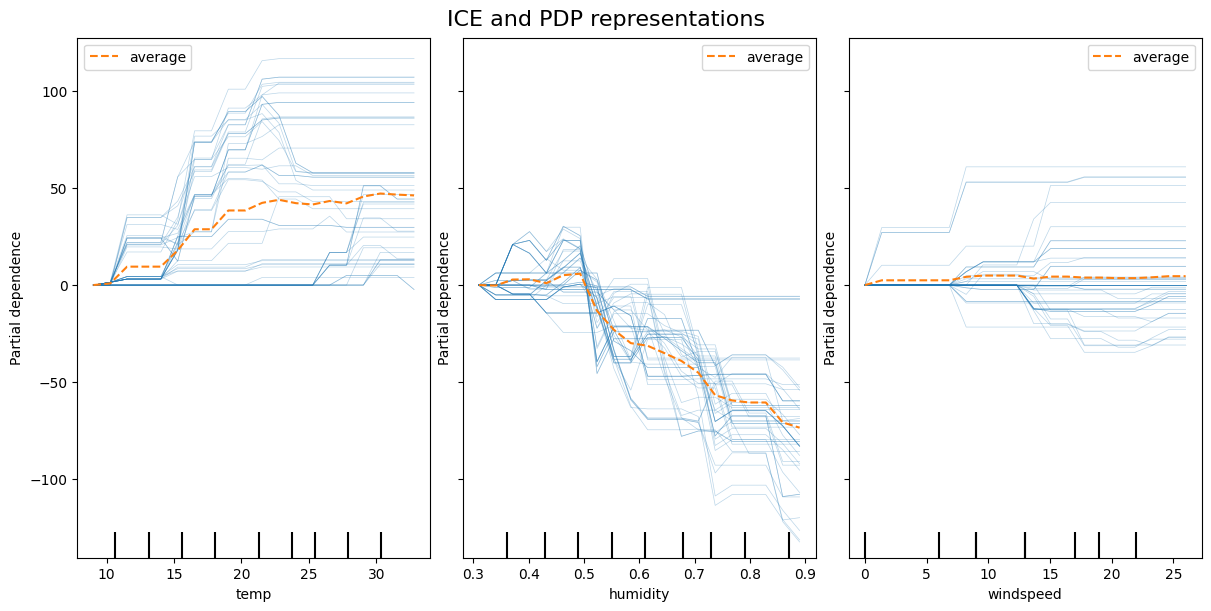

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model, # Pre-trained gradient boosed regressor tree model
    data, # Data to plot
    features=["temp", "humidity", "windspeed"], # Features to plot from the dataframe
    kind="both",  # This will plot both PDP and ICE
    centered=True, # Center the ICE curves becaue we are only interested in the shape of the curve not the absolute values
    subsample=50, # Subsample the data to speed up the plotting, we only plot 50 instances
    n_jobs=2, # Use 2 cores to speed up the computation
    grid_resolution=20, # Number of points in the grid, the higher the better the resolution
    random_state=0, # Set the random state for reproducibility
    ax=ax) # Plot the ICE and PDP on the same axis
display.figure_.suptitle("ICE and PDP representations", fontsize=16) # Set the title of the plot
plt.show() # Show the plot
plt.close() # Close the plot to free up memory

### Section 1 | Understand PDP and ICE curves by replicating sklearn plots with your own code


Using your theoretical knowledge from LO1, your task is to manually calculate both the PDP and ICE curves. For this, you will only require the **model** and **data** loaded above. The data is stored in a pandas dataframe, and the model is a pre-trained tree regression model. You can view the dataframe's first few entries using the method `data.head()`. Remember to vectorize your code; you should only ever require a single for loop and never a nested loop.

**1.1 | Manually compute the PDP curve for the target feature "temp" and plot the result**

Remember: The PDP formula, $f_{PDP}^p(x^p) = \mathbb{E}_{X_{-p}}[f(x^1, x^2, \ldots, x^p, \ldots, x^k)]$, calculates the marginal effect of the feature $x^p$ on the predicted outcome by averaging the predictions of the function $f$ over the joint distribution of all other features $X_{-p}$. Remember to sort the dataset according to the temp value before calculating and plotting.

In [1]:
# YOUR CODE HERE

***1.2 | Manually compute the ICE curves for the target feature of temp and plot the results***

Remember, a single ICE curve consists of the model predictions over a fixed instance while varying the feature of interest. It is extremely computationally expensive to calculate ICE curves for all instances, therefore randomly sample and plot the ICEs of 50 instances only.

In [28]:
# YOUR CODE HERE

***1.3 | Center the ICE curves and plot the results as well as the average on the same axes***

It is often difficult to interpret ICEs because the plot is unorderly. Since we are only interested in trends and not absolute values, i.e., does the predicted target increase, decrease, or remain the same as we vary the input. One way to center the ICE is to subtract a constant baseline. Selecting the baseline as the predicted value when selecting the anchor as the smallest feature value will ensure all ICE curves start from zero.

In [2]:
# YOUR CODE HERE

***1.4 | Discuss your results***

In [ ]:
# YOUR ANSWER HERE

### Section 2 | Try and determine what rule the mystery model is using for its predictions on the mystery dataset

***2.1 | Plot the PDP and ICE curves for both "Feature1" and "Feature2"***

In [ ]:
# Import mystery data and model
X = pd.read_csv('../data/mystery_data.csv')
model = joblib.load('../models/mystery_model.pkl')
X.head()

In [3]:
# YOUR CODE HERE

***2.2 | Analyze and discuss the results. If you cannot explain the model's decisions, then argue your point.***

In [ ]:
# YOUR ANSWER HERE

# ***L01:*** Shapley Vlaues (Theory and Application)

<img src="./static/SHAP.png" width="1500" alt="image description">

## Introduction
In this notebook, we will test both your understanding of the theory of Shapley values and your ability to interpret the results. The first task should allow you to better understand the principle equation of Shapley values

$$ 
\phi_i(x)=\sum_{S \subseteq N \backslash\{i\}} \frac{|S|!\times(|N|-|S|-1)!}{|N|!}\left(f_\theta(S \cup\{i\})-f_\theta(S)\right),
$$

and how they are calculated. You should be led to an understanding of the computational complexities involved in Shapley value calculations. You will then code your own approximate solution to the Shapley value problem and compare the results to the SHAP library.

## Using the SHAP Library
You will then use the SHAP library (https://shap.readthedocs.io/en/latest/index.html) to explain and interpret the predictions of two models. This library not only contains fast approximate methods such as KernelSHAP and TreeSHAP that you have encountered in the learning materials, but it also has built-in visualizations that can be used to interpret the results of the SHAP values. Visualizations include summary/beeswarm plots, dependence plots, force plots, and waterfall plots. These visualization tools allow you to analyze the impact of each feature on the output of the model at different levels of granularity. The plotting methods can be used to display both local explanations (per instance) and global explanations to say something meaningful about the features over the entire dataset.

## Datasets and Models
We will analyze two pairs of datasets and models.
1. **Titanic Dataset**: The first dataset is the Titanic dataset (`titanic_data.csv`), which contains information about the passengers on the Titanic. A tree ensemble model (`titanic_model.pkl`) was trained on the regression task of predicting whether a passenger survived or not.
2. **Mystery Dataset**: The second dataset is the mystery dataset and model from the last exercise (`mystery_data.csv`, `mystery_model.pkl`). 

You will use the SHAP library to enhance or resolve your arguments regarding the models' decision-making processes. Please note that the datasets do not contain the target values, however the targets were used to train the models.

------------
### Section 1 | Understanding the normalization factor in the Shapley value calculation    
- 1.1 Create a function in Python to calculate the weighting factor $\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$ in the Shapley value formula above. The function should take in two arguments, i.e., `shapley_weight_factor(n, s)` where $n$ is the total number of features and $s$ is the size of the subset. The function should output the weight assigned to each coalition of size $|S|$.
- 1.2 Use the function to sum the values of all possible coalitions and print your result.
- 1.3 Plot the number of combinations/coalitions as a function of subset size $|S|$. On the same axis, include a plot of the associated weight factor for each subset.
- 1.4 Explain why the weighting factor is necessary. Think about what kind of bias we could expect if we did not weight the values.

### Section 2 | Calculating Shapley values using Monte Carlo approximation 
- 2.1 If we want to calculate the Shapley values exactly for a single feature of a single instance/row, how many calculations have to be performed? Provide your reasoning and answer for the case of $n=4$ features.  
- 2.2 Approximate Calculation of Shapley Values Using Monte Carlo  

### Section 3 | Using the SHAP library to analyze the Titanic dataset

- 3.1 | Use the SHAP library to calculate the Shapley value for all features and instances of the Titianic dataset
- 3.2 | Identify and Rank the Importance of Each Feature for the Model's Decisions, Plot and Discuss the Results
- 3.4 | Compare a PDP plot for `Age` with a SHAP dependancy plot. What additional information do we gain?  
- 3.5 | Plot a SHAP feature dependence plot for 'Age' with interaction visualization for the passengers' Sex. Interpret the results
- 3.6 | Remove all the individual effects of the features and plot only the pure interaction between 'Age' and 'Class'
- 3.7 | Local Shapley Explanations

### Section 4 | Determine the decision making process of the mystery model
------------

Import necessary libraries

In [ ]:
import shap # for calculating Shapley values using the SHAP library
import joblib # for saving and loading models from sklearn
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for tabular data manipulation
import xgboost as xgb # for training the XGBoost model
from math import factorial # for calculating the number of combinations
import matplotlib.pyplot as plt # for plotting
from itertools import combinations # for generating all possible combinations
import warnings
warnings.filterwarnings('ignore')
shap.initjs() # Visualize the SHAP values for the instance
# Create a color map
from matplotlib.colors import LinearSegmentedColormap
color_high = 'sandybrown'  # Color for high feature values
color_low = 'skyblue' # Color for low feature values
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color_low, color_high])

### Section 1 | Understanding the Normalization Factor in the Shapley Value Calculation    

The image below depicts four hypothetical features representing a model's inputs. The colored shapes could represent class attendance, pre-exam results, hours of self-study, and age in a regression model trained to predict final exam results. Shapley values are calculated by computing and summing the model's output over all possible coalitions of features, with each result appropriately normalized. Here, we want to examine the normalization factor and how it relates to the total number of features and subset size. The image below shows all the possible coalitions if we were interested in calculating the contribution of the star to the model's output.

<img src="./static/shapley_weights.png" width="500" alt="image description">

**1.1 | Create a function in Python to calculate the weighting factor $\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$ in the Shapley value formula above. The function should take in two arguments, i.e., `shapley_weight_factor(n, s)` where $n$ is the total number of features and $s$ is the size of the subset. The function should output the weight assigned to each coalition of size $|S|$.**

In [ ]:
def shapley_weight_factor(n, s):
    """
    Calculate the Shapley weight factor for a subset of size s with total n features.
    """
    # YOUR CODE HERE
    
    return weight

***1.2 | Use the function to sum the values of all possible coalitions and print your result.***

In [ ]:
# YOUR CODE HERE

**1.3 | Plot the number of combinations/coalitions as a function of subset size $|S|$. On the same axis, include a plot of the associated weight factor for each subset.**

In [ ]:
# YOUR CODE HERE

***1.4 | Explain why the weighting factor is necessary. Think about what kind of bias we could expect if we did not weight the values.***

In [ ]:
# YOUR EXPLANATION HERE

### Section 2 | Calculating Shapley Values Using Monte Carlo Approximation

Although Shapley values are the ideal quantity for model explanations, there are two reasons we have to develop approximate methods to calculate them. Firstly, the computational cost (which we will explore in this section) is exponential with the number of features $n$, meaning if we want to find the attributions of images, text, or large tabular datasets, we will not be able to compute the values exactly. Secondly, we have seen that the exact Shapley value calculation requires a summation over all subsets of features. However, most ML models require inputs along each feature dimension to produce a prediction. This means we cannot simply feed in 4 features to a model that was trained to accept 8. In this case, we need to develop the idea of a baseline. A baseline is a value that can be fed into the model that represents "missingness", i.e., lack of input feature. If we find such a baseline, then we can flood the appropriate feature channels with the baseline to turn features off and effectively create a subset. The choice of baseline must be made very carefully.

We will look at the Monte Carlo approximation for calculating Shapley values. This method "turns features off" using a random baseline sampled from the dataset. Imagine a model that has been trained on a dataset with only 3 features. If we want to get rid of the effect of a single feature channel $j$, we could flood it with noise $q\sim \mathcal{N}(\mu, \sigma^2)$ from a normal distribution. In this case, the noise would not have the desired effect of a baseline since it will most definitely affect the model's output, i.e., $f_\theta(x_{j\to q_1}) \neq f_\theta(x_{j\to q_2})$. However, if we sample enough values $q_i$ from the normal distribution, the effects will cancel out and the expected value will converge $\mathbb{E}_{q\sim\mathcal{N}}[f_\theta(x_{j\to q})]=\text{constant}$. This idea is problematic for two reasons: firstly, sampling from noise implies that the features are not correlated since we are modeling them as independent, which for most cases is not true. Secondly, this assumption is prone to generate unrealistic samples outside of the model's training. 

Although sampling from a normal distribution is flawed, the idea of generating a baseline that does not affect the output from an expectation value is useful. The Monte Carlo approximation fixes the issues by sampling feature values from data instances themselves instead of random uncorrelated noise. The idea of baselines will be very important in this course. Remember that a baseline is a signal that we can send through our model, such that it effectively "turns off" the contribution of channels allowing us to create the subsets necessary to calculate Shapley values.

**2.1 | If we want to calculate the Shapley values exactly for a single feature of a single instance/row, how many calculations have to be performed? Provide your reasoning and answer for the case of $n=4$ features.**

In [ ]:
# YOUR EXPLANATION HERE

**2.2 | Approximate Calculation of Shapley Values Using Monte Carlo** 

If the number of calculations necessary for a single Shapley value scales exponentially with the number of features, we require approximate methods. Code your own version of the Monte Carlo approximation, as discussed in the summary materials, to estimate the Shapley values of all four features for a single instance of the "bike_sharing_data" dataset and "bike_sharing_model" model. Compare your result with the output generated by the SHAP library.

Follow these steps:

1. Create a function that Implements the Monte Carlo approximation to estimate Shapley values.
2. Apply your implementation to estimate the Shapley values for all four features of a single instance from the "bike_sharing_data" dataset.
3. Compare your estimated Shapley values with those produced by the SHAP library.
4. Experiment with different numbers of Monte Carlo samples. Increase or decrease the number of samples and observe the changes in the estimated Shapley values.
5. Interpret your results, considering how the number of Monte Carlo samples affects the accuracy and stability of the Shapley value estimates.

By completing this exercise, you will gain an understanding of how the Monte Carlo approximation works, and how the effectiveness of baslines depends on the number of samples.

<img src="./static/shapley_monte_carlo.png" width="1000" alt="image description">

In [ ]:
# Load the model and data
model = joblib.load('../models/bike_sharing_model.pkl')

# Load the data
data = pd.read_csv('../data/bike_sharing_data.csv')

In [ ]:
# Your function for implementing the Monte Carlo approximation

def monte_carlo_shapley_values(data: pd.DataFrame, model: object, M: int, sample_idx: int) -> list:
    """
    Calculate the Shapley values for all features using the Monte Carlo approximation.
    Parameters:
    data (pd.DataFrame): The dataset.
    model (sklearn-like model): The model to evaluate.
    M (int): The number of Monte Carlo simulations (evaluated coalitions).
    Returns:
    list: Shapley values for each feature.
    """
    shapley_feature_values = []  # Initialize the list to store the Shapley values
    x = data.iloc[sample_idx].copy() # Extract the instance to explain
    n_features = data.shape[1]  # Number of features

    # YOUR CODE HERE

    return shapley_feature_values

In [ ]:
# Wrap the sklearn pipeline model for SHAP compatibility
def shap_wrapper(model):
    def f(x):
        return model.predict(x)
    return f

# Calculate the Shapley values using the Monte Carlo method and compare them with the SHAP values by taking the L2 norm of the difference
residuals = [] # to collect the differences between our monte carlo shapley values and the values from the SHAP library
n_itters = list(range(2, 20, 1)) # number of different Monte Carlo iterations to try
inst = 0 # instance to explain
x = data.iloc[inst] # extract the instance to explain
for n_itter in n_itters: # iterate over the number of iterations

    # YOUR CODE HERE   

In [ ]:
# Plot the residuals

In [ ]:
# YOUR EXPLANATION HERE

### Section 3 | Using the SHAP library to analyze the Titanic dataset  

In this section, we will use fast approximate methods to calculate Shapley values and analyze the Titanic dataset at different levels of granularity. By the end of this section, you should be able to interpret a wide variety of built-in SHAP plotting functions.

**3.1| Use the SHAP library to calculate the Shapley value for all features and instances of the Titianic dataset**

In [ ]:
# Load the data
data = pd.read_csv('../data/titanic_data.csv')

# Load the model
model = joblib.load('../models/titanic_model.pkl')

In [ ]:
# Calculate the SHAP values

# YOUR CODE HERE

**3.2 | Identify and Rank the Importance of Each Feature for the Model's Decisions, Plot and Discuss the Results**

Evaluating the importance of features is straightforward. Features with larger absolute Shapley values are more important for the model's decisions. Therefore, the feature's global importance is calculated as

$$
I_j = \frac{1}{n}\sum^n_{i=1}|\phi^{(i)}_j|.
$$

You can either calculate this manually and generate a bar plot, or use the SHAP built-in summary plotting function with `plot_type='bar'`.

In [ ]:
# Identify feature importance using the SHAP bar plot 

# Your CODE HERE

The bar plot indicates that the factors contributing most to survival are Sex, Class, and Age. However, this information does not show the relationship between the predicted outcome and the feature values. For a more detailed view, we can use a SHAP summary (beeswarm) plot.

**3.3 | Use SHAPs built in summary/beeswarm plot and interpret the results**

In [ ]:
# Plot a bee swarm plot for the SHAP values

# YOUR CODE HERE

When interpreting the summary plot, consider the following points:

- **Vertical Axis**: Indicates feature importance, which corresponds to the same order as the bar plot.
- **Horizontal Position**: Shows whether the effect of a feature value is associated with a higher or lower prediction.
- **Color**: Represents whether that feature's value is high or low for that particular instance of the dataset.
- **Vertical Dispersion (Thickness)**: Is a proxy for the amount of feature interaction. Thick areas suggest a high interaction or dependence with other features.

In [ ]:
# YOUR EXPLANATION HERE

**3.4 | Compare a PDP plot for `Age` with a SHAP dependancy plot. What additional information do we gain?**  

In [ ]:
# Calculate the PDP curve for a single feature

# Select the feature to compare
feature_name = 'Age'

# Prepare data
data_sorted = data.sort_values(by=feature_name)  # Order the rows of the data according to the value of the target feature
feature_values = data_sorted[feature_name]  # Get the target feature values
feature_values_unique = feature_values.unique()  # Get the unique values of the target feature
xax = feature_values_unique.copy()  # These are the x-axis values for the PDP curve

# Calculate PDP curve
pdp_curve = []  # List to store the PDP curve

# YOUR CODE HERE

In [ ]:
# Plot SHAP values and PDP curve on the same plot but with different y-axes

# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE

**3.5 | Plot a SHAP feature dependence plot for 'Age' with interaction visualization for the passengers' Sex. Interpret the results**

In [ ]:
# Plot a SHAP feature dependence plot with interaction visualization

# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE

**3.6 | Remove all the individual effects of the features and plot only the pure interaction between 'Age' and 'Class'**  

Formerly the SHAP library will is calculate

$$
\phi_{i, j}=\sum_{S \subseteq \backslash\{i, j\}} \frac{|S|!(M-|S|-2)!}{2(M-1)!} \delta_{i j}(S),
$$

where $i\neq j$, and

$$
\delta_{i j}(S)=\hat{f}_x(S \cup\{i, j\})-\hat{f}_x(S \cup\{i\})-\hat{f}_x(S \cup\{j\})+\hat{f}_x(S).
$$

In other words we subtract the main effects by accounting for individual feature effects.

In [ ]:
# Calculate the pure SHAP interaction values (One M times M matrix for each instance)

# YOUR CODE HERE

In [ ]:
#Plot the pure SHAP interaction values for the Age and Sex features

# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE

**3.7 | Local Shapley Explanations**

Plot a waterfall plot for three individuals: the one most likely to survive according to the model, the one least likely to survive, and an average passenger. Interpret the results.

In [ ]:
# YOUR CODE HERE

Each waterfall plot represents a single point on the beeswarm plot. These plots provide local explanations on a per-instance basis, allowing us to precisely determine the factors contributing to or detracting from an individual's survival probability. The individual most likely to survive is a high-paying, middle-aged, first-class female passenger, while the lowest survival probability is assigned to a low-paying, elderly, third-class male passenger.

### Section 4 | Determine the decision making process of the mystery model  

Here you should have developed all the tools necessary to quickly identify the mechanism of decision for this simple model.  

In [ ]:
# Load the mystery data 
X = pd.read_csv('../data/mystery_data.csv')

# Load the mystery model
model = joblib.load('../models/mystery_model.pkl')

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR EXPLANATION HERE